In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [17]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables
Measurement = Base.classes.measurement
Station = Base.classes.station

C:\Users\lisam\AppData\Local\Temp\ipykernel_79680\3564203001.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [18]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [19]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [20]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [23]:
# Find the most recent date in the data set.
latest_date = session.query(func.max(Measurement.date)).scalar()

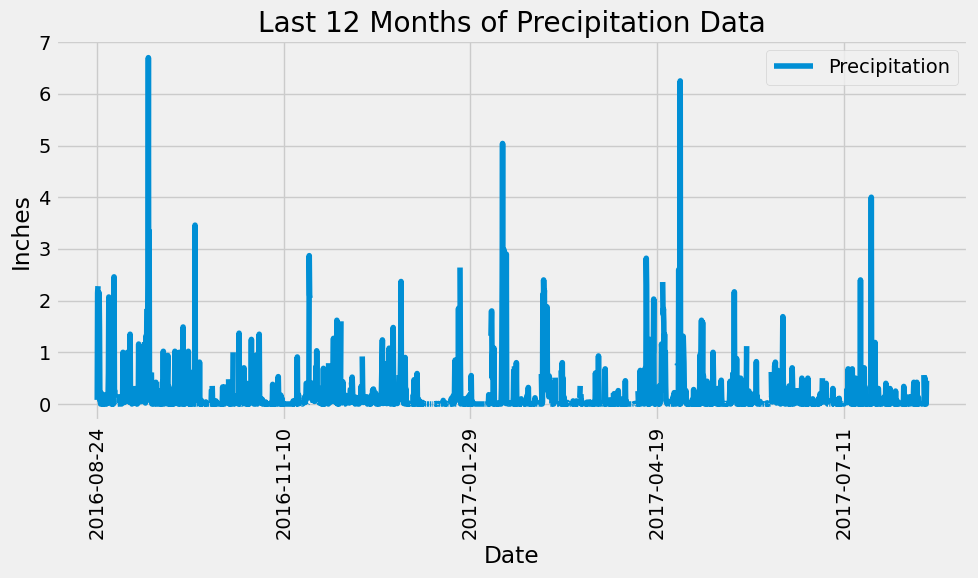

In [36]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = dt.datetime.strptime(latest_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index('date', inplace=True)

# Sort the dataframe by date
df = df.sort_values(by='date', ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(figsize=(10, 6), rot=90)
plt.title("Last 12 Months of Precipitation Data")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(["Precipitation"])
plt.tight_layout()
plt.show()



In [25]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = df.describe()
print(summary_stats)

       precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [26]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f'There are {total_stations} stations in the dataset')

There are 9 stations in the dataset


In [33]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station))\
                        .group_by(Measurement.station)\
                        .order_by(func.count(Measurement.station).desc())\
                        .all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [29]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]
temp_stats = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs))\
                        .filter(Measurement.station == most_active_station)\
                        .all()
print(f"Temperature Stats for {most_active_station}:")
print(f"Lowest Temperature: {temp_stats[0][0]}")
print(f"Average Temperature: {round(temp_stats[0][1], 2)}")
print(f"Highest Temperature: {temp_stats[0][2]}")

Temperature Stats for USC00519281:
Lowest Temperature: 54.0
Average Temperature: 71.66
Highest Temperature: 85.0


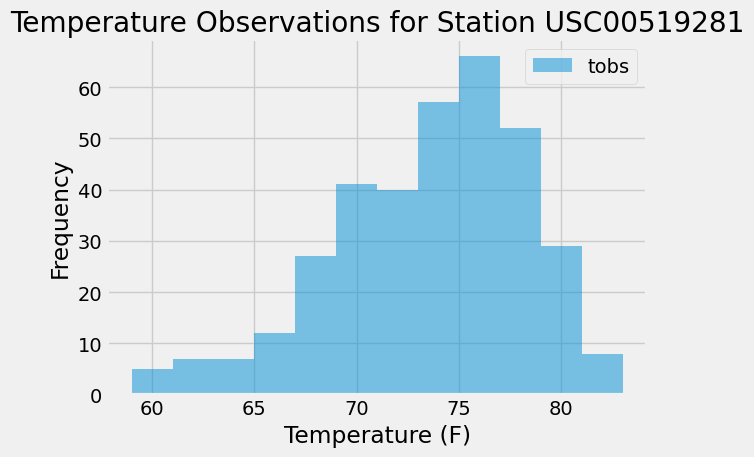

In [37]:
# Query the last 12 months of temperature observation data for this station 
temp_data = session.query(Measurement.tobs)\
                   .filter(Measurement.station == most_active_station)\
                   .filter(Measurement.date >= one_year_ago)\
                   .all()

# Plot the results as a histogram
temp_df = pd.DataFrame(temp_data, columns=['tobs'])
temp_df.plot.hist(bins=12, alpha=0.5)
plt.title(f"Temperature Observations for Station {most_active_station}")
plt.xlabel("Temperature (F)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Close session

In [32]:
# Close Session
session.close()